using Revise

```julia
Pkg.update("DataStructures")
```

```julia
    import Pkg
    Pkg.add(Pkg.PackageSpec(url = "https://github.com/menchelab/RMP.jl.git"))
    using RMP
```

In [1]:
using CSV, StatsBase, Statistics, DataFrames, UMAP, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed
using RMP

┌ Info: Precompiling RMP [cef322dc-4d82-11ea-04a7-113231db804d]
└ @ Base loading.jl:1278


In [2]:
using Dates: now
now()

2020-11-13T16:30:04.29

## R Calls

In [3]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [4]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import("/tmp/.fonts")
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Registering fonts with R
└ @ RCall /opt/julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Scanning ttf files in /tmp/.fonts ...
│ Extracting .afm files from .ttf files...
│ /tmp/.fonts/Arial.ttf : ArialMT already registered in fonts database. Skipping.
│ Found FontName for 0 fonts.
│ Scanning afm files in /opt/conda/lib/R/library/extrafontdb/metrics
│ Warning in grepl("^FamilyName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FontName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FullName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^Weight", text) :
│   input string 4 is invalid in this locale
└ @ RCall /opt/julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Arial already registered with pdfFonts().
└ @ RCall /opt/julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Load measurements

### Load annotations

In [5]:
annotations = CSV.read("data/transferList.txt", header = 1, delim = "\t")# Convert plate number to strings to make clear it is an ID and should not be used for computations
annotations[:DestinationPlate] = string.(annotations[:DestinationPlate])
# Wells in the transfer list without any compound name are filled with DMSO only
annotations[:CompoundName][ismissing.(annotations[:CompoundName])] .= "DMSO"
# A non-ASCII characters needs to be converted
annotations.CompoundName = replace.(annotations.CompoundName, "\xb1" => s"±");

In [6]:
annotations

,DestWell,SourcePlate_A,SrcWell_A,DestinationPlate,Type_A,VolumeTransferred_A
,String,String,String,String,String,Int64
1,A01,CLOMP_D4,M04,1914001,Cpd,100
2,A02,CLOUD10mM10,I19,1914001,Cpd,100
3,A03,CLOUD10mM10,A10,1914001,Cpd,100
4,A04,CLOMP002a,L04,1914001,Cpd,100
5,A05,CLOUD10mM10,I05,1914001,Cpd,100
6,A06,CLOMP002a,B11,1914001,Cpd,100
7,A07,CLOMP001a,F15,1914001,Cpd,10
8,A08,CLOMP003a,I20,1914001,Cpd,100
9,A09,CLOUD10mM10,M19,1914001,Cpd,100


### Load image data

In [7]:
image = CSV.read("data/compiled_PilotDrugScreen_Image_750.csv")
println(string.(names(image))[1:8])
# Number of images and features available
println(nrow(image))
println(ncol(image))

["Column1", "AreaOccupied_AreaOccupied_CytoCM", "AreaOccupied_AreaOccupied_Cytoplasm", "AreaOccupied_AreaOccupied_Nucleus", "AreaOccupied_Perimeter_CytoCM", "AreaOccupied_Perimeter_Cytoplasm", "AreaOccupied_Perimeter_Nucleus", "AreaOccupied_TotalArea_CytoCM"]
7680
1916


### Load individual cell files

In [ ]:
nucleus = CSV.read("data/compiled_PilotDrugScreen_Nucleus_750.csv", header = 1);

In [ ]:
# Remove duplicated columns
nucleus = nucleus[:, Not([1,6,8,12,14,16])];

In [ ]:
cytocm = CSV.read("data/compiled_PilotDrugScreen_CytoCM_750.csv", header = 1);

In [ ]:
# Remove duplicated columns
cytocm = cytocm[:, Not([1,6,8,12,14,16])];

In [ ]:
cytoplasm = CSV.read("data/compiled_PilotDrugScreen_Cytoplasm_750.csv", header = 1);

In [ ]:
# Remove duplicated columns
cytoplasm = cytoplasm[:, Not([1,6,8,12,14,16])];

### Merge measurements

In [ ]:
cell = innerjoin(cytoplasm, cytocm, on = [:ImageNumber => :ImageNumber, :Parent_CytoCM => :ObjectNumber], 
       makeunique = true)

In [ ]:
cell = innerjoin(cell, nucleus, on = [:ImageNumber => :ImageNumber, :Parent_Nucleus => :ObjectNumber], 
       makeunique = true)

In [ ]:
# NB: columns with missing values should not be provided even if they are not used by ggplot
ggplot(cell[1:10000,[:AreaShape_Center_X, :AreaShape_Center_X_1]], 
       aes(x = :AreaShape_Center_X, y = :AreaShape_Center_X_1)) + geom_point()

In [ ]:
# NB: columns with missing values should not be provided even if they are not used by ggplot
ggplot(cell[1:10000,[:AreaShape_Center_X_1, :AreaShape_Center_X_2]], 
       aes(x = :AreaShape_Center_X_1, y = :AreaShape_Center_X_2)) + geom_point()

In [ ]:
# NB: columns with missing values should not be provided even if they are not used by ggplot
ggplot(cell[1:10000,[:AreaShape_Center_X, :AreaShape_Center_X_2]], 
       aes(x = :AreaShape_Center_X, y = :AreaShape_Center_X_2)) + geom_point()

In [ ]:
# Free up memory
nucleus = nothing
cytoplasm = nothing
cytocm = nothing

## Experiment filtering

In [ ]:
cell.URL = "images/r".*lpad.(cell.Metadata_Row, 2, "0").*
    "c".*lpad.(cell.Metadata_Column, 2, "0").*
    "f".*lpad.(cell.Metadata_Field, 2, "0").*"p01rc1-ch1sk1fk1fl1.tiff";

In [ ]:
cell.PlateNumber = [x == "1500CellsPerWell" ? "1914001" : "1914011" for x in cell.Metadata_Plate];

In [ ]:
cell = leftjoin(cell, annotations[[:CompoundName,:DestWell,:DestinationPlate]], 
                    on = [:Metadata_Well => :DestWell, :PlateNumber => :DestinationPlate])

# Wells absent of the transfer list do not have any compound in them
cell.CompoundName[ismissing.(cell.CompoundName)] .= "None";

```julia
# Export `cell` dataframe to avoid reprocessing if not needed
CSV.write("data/compiled_cell_750.csv", cell)
```

```julia
# If data was already compiled and exported, load the `cell` dataframe.
cell = CSV.read("data/compiled_cell_750.csv")
```

In [ ]:
ftb = freqtable(cell[:CompoundName])
ftb[sortperm(ftb)]

In [ ]:
xp = Experiment(cell, description = "All measurements for plate @750c/well.")

In [ ]:
# Make sure to remove columns that are not morphological measurements
strToRemove = ["Parent", "ObjectNumber", "ImageNumber", "Experiment",
                "Object_Number", "Location", "Center", "Metadata", "Orientation",
                "PlateNumber", "CompoundName", "Texture", "Neighbors_AngleBetweenNeighbors_5",
                "Neighbors_SecondClosestDistance_5", "URL"]
# NB: Textural features have missing values
filters = Array{RMP.AbstractReduce}([NameSelector(x -> !any(occursin.(strToRemove, String(x))))])

### Which cells to filter?

In [ ]:
# Cells with cytoCM much larger than nucleus
ggplot(cell[1:10000,[:AreaShape_Area_2, :AreaShape_Area_1]], 
       aes(x = :AreaShape_Area_2, y = :AreaShape_Area_1)) + geom_point() +
    geom_abline(intercept = 0, slope = 4)

In [ ]:
cell.Metadata_Ratio1 = cell.AreaShape_Area_1 ./ cell.AreaShape_Area_2
push!(filters, Filter(4, :Metadata_Ratio1, compare = <, description = "Exclude cells with really large cytoCM"))
negf1 = negation(filters[end]);

In [ ]:
# Cells with cytoplasm much larger than cytoCM
ggplot(cell[1:10000,[:AreaShape_Area, :AreaShape_Area_1]], 
       aes(x = :AreaShape_Area_1, y = :AreaShape_Area)) + geom_point() +
    geom_abline(intercept = 0, slope = 10)

In [ ]:
cell.Metadata_Ratio2 = cell.AreaShape_Area ./ cell.AreaShape_Area_1
push!(filters, Filter(10, :Metadata_Ratio2, compare = <, description = "Exclude cells with really large cytoplasm"))
negf2 = negation(filters[end]);

In [ ]:
# Cells with non-round nuclei (mostly segmentation mistakes)
ggplot(cell[1:10000,[:AreaShape_Area_2, :AreaShape_FormFactor_2]], 
       aes(x = :AreaShape_Area_2, y = :AreaShape_FormFactor_2)) + geom_point() +
    geom_hline(yintercept = 0.5)

In [ ]:
push!(filters, Filter(0.5, :AreaShape_FormFactor_2, compare = >, description = "Keep roundish nuclei"))
negf3 = negation(filters[end]);

In [ ]:
# Cells with CellMask clots
ggplot(cell[1:10000,[:Intensity_MaxIntensity_CorrCM_1, :Intensity_StdIntensity_CorrCM_1]], 
       aes(x = :Intensity_MaxIntensity_CorrCM_1, y = :Intensity_StdIntensity_CorrCM_1)) + geom_point() +
    geom_vline(xintercept = 0.1)

In [ ]:
push!(filters, Filter(0.1, :Intensity_MaxIntensity_CorrCM_1, compare = <, description = "Keep roundish nuclei"))
negf4 = negation(filters[end]);

### Example images
Here we highlight examples of cells which were filtered out and cells which were kept. 

In [ ]:
# Convert paths to all channels
rgbrgx = [
    [],
    ["rc1" => "rc2"],
    ["rc1" => "rc3"]]

In [ ]:
# This is the description of the cells highlighted (i.e. they have an usually large cytoCM)
println(negf1.description)
diagnosticImages(xp, negf1, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

In [ ]:
println(negf2.description)
diagnosticImages(xp, negf2, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

In [ ]:
println(negf3.description)
diagnosticImages(xp, negf3, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

In [ ]:
println(negf4.description)
diagnosticImages(xp, negf4, :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

### Apply filters

In [ ]:
selectExperiment!(xp, filters)

In [ ]:
# No measurements are missing!
tdf = xp.data[xp.selectedEntries, xp.selectedFeatures]
@assert sum(Array(mapcols(x -> sum(ismissing.(x)), tdf))[1,:]) == 0
# Free up memory
tdf = nothing

```julia
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"));
```

In [ ]:
xp

In [ ]:
# Example of cells kept
diagnosticImages(xp, filters[end], :URL, 
                    saveimages = false, show = true,
                    rgb = rgbrgx, showlimit = 3, center = true)

## Coarse-grain aggregation

In [ ]:
gd = groupby(xp.data[xp.selectedEntries,[xp.selectedFeatures...,
                                           findfirst(names(xp.data) .== "Metadata_Well"),
                                           findfirst(names(xp.data) .== "Metadata_Row"),
                                           findfirst(names(xp.data) .== "Metadata_Column"),
                                           findfirst(names(xp.data) .== "CompoundName"),
                                           findfirst(names(xp.data) .== "Metadata_Field")]],
    [:Metadata_Well, :CompoundName, :Metadata_Field, :Metadata_Row, :Metadata_Column])
aggregatedData = DataFrames.combine(gd, valuecols(gd) .=> median);

In [ ]:
# Checkpoint to avoid recomputing the whole filtering
CSV.write("data/aggregatedData_750cells.csv", aggregatedData)

If the data was already exported:
```julia
aggregatedData = CSV.read("data/aggregatedData_750cells.csv");
```

In [8]:
aggregatedData = CSV.read("data/aggregatedData_750cells.csv");

### Transform aggregated data - Normalization
We want to focus on variables that are changing more overall than inside of reference condition (untreated WT).

In [9]:
expAgg = Experiment(aggregatedData, description = "Median values for aggregated FOV measurements")

"Experiment with 6444/6444 entries and 390/390 features selected."

In [10]:
filters = Array{RMP.AbstractSelector,1}()
# Remove metadata
strToRemove = ["Metadata_Well", "CompoundName", "Metadata_Field", "Metadata_Row", "Metadata_Column"]
push!(filters, NameSelector(x -> !any(occursin.(strToRemove, String(x)))))
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"))
selectFeaturesExperiment!(expAgg, filters)

In [11]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [12]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selectedFeatures] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
end

## Visualization

In [13]:
function UMAP.umap(e::Experiment, n_components=2; kwargs...)
    umap(convert(Matrix, getdata(e))', n_components; kwargs...)
end

In [ ]:
startTime = now()
Random.seed!(3895)
umTPM = umap(expTransformed, 2)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
print(now() - startTime)

In [ ]:
size(umTPM)

In [ ]:
umTPM.Compound = aggregatedData.CompoundName
ggplot(umTPM, aes(:UMAP1, :UMAP2)) + geom_point(aes(color = :Compound), alpha = 0.3) +
    scale_colour_discrete(guide = false)

In [ ]:
ggplot(umTPM[umTPM.Compound .== "DMSO",:], aes(:UMAP1, :UMAP2)) + geom_point(aes(color = :Compound), alpha = 0.3)

In [ ]:
subsetCompounds = ["Vinblastine", "Vincristine sulfate", "Wiskostatin", "Y-27632 dihydrochloride"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8)

In [ ]:
subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

In [ ]:
umap_model = UMAP_(convert(Matrix, getdata(expTransformed))', n_neighbors = 50)
umap_model.graph

In [ ]:
import Pkg; Pkg.add("LightGraphs")

In [ ]:
Pkg.add("SimpleWeightedGraphs")

In [ ]:
using LightGraphs, SimpleWeightedGraphs

In [ ]:
g = SimpleWeightedGraph(umap_model.graph)

In [ ]:
Pkg.add("Plots")
Pkg.add("GraphRecipes")

In [ ]:
using Plots, GraphRecipes

In [ ]:
graphplot(g)

In [19]:
import Pkg; Pkg.add("Distances")

   Updating registry at `/opt/julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
Updating `/opt/julia/environments/v1.5/Project.toml`
  [b4f34e82] + Distances v0.9.2
No Changes to `/opt/julia/environments/v1.5/Manifest.toml`


In [20]:
using Distances

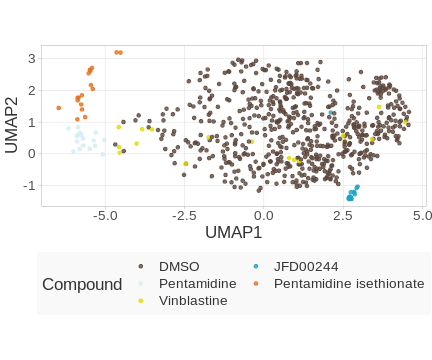

RObject{VecSxp}


In [36]:
Random.seed!(3895)
umTPM = umap(expTransformed, n_neighbors = 20, metric = Euclidean(), min_dist = 0.1, spread = 1)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

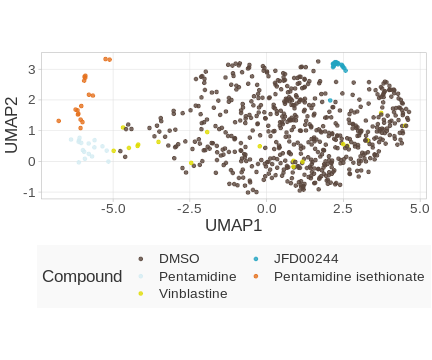

RObject{VecSxp}


In [22]:
Random.seed!(3895)
umTPM = umap(expTransformed, n_neighbors = 15, metric = Euclidean(), min_dist = 0.1, spread = 1)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

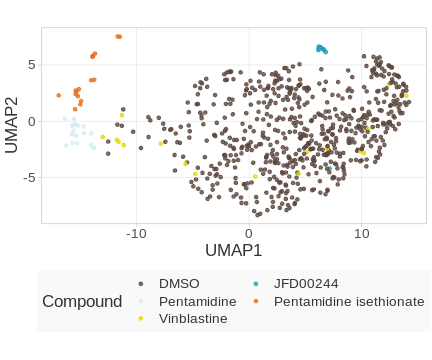

RObject{VecSxp}


In [27]:
Random.seed!(3895)
umTPM = umap(expTransformed, n_neighbors = 10, metric = Euclidean(), min_dist = 0.001, spread = 3)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

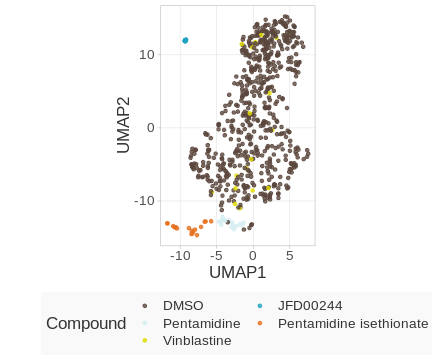

RObject{VecSxp}


In [30]:
Random.seed!(3895)
umTPM = umap(expTransformed, n_neighbors = 10, metric = CosineDist(), min_dist = 0.01, spread = 3)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

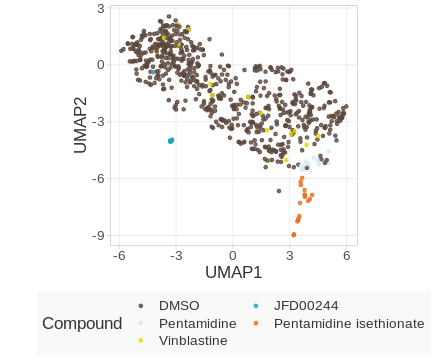

RObject{VecSxp}


In [35]:
Random.seed!(3895)
umTPM = umap(expTransformed, n_neighbors = 6, metric = CorrDist(), min_dist = 0.1, spread = 1)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

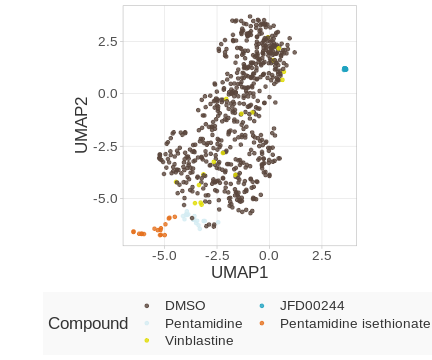

RObject{VecSxp}


In [33]:
Random.seed!(3895)
umTPM = umap(expTransformed, n_neighbors = 10, metric = CorrDist(), min_dist = 0.1, spread = 1)
umTPM = convert(DataFrame, umTPM')
names!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = aggregatedData.CompoundName

subsetCompounds = ["Vinblastine", "Pentamidine", "JFD00244", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umTPM.Compound), subsetCompounds)))[1])
ggplot(umTPM[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))